# Getting started with using FeedbackParticleFilters.jl

In [1]:
using FeedbackParticleFilters
using Distributions
using PyPlot

## Setting up a filtering problem

Here, we set up a basic one-dimensional linear-Gaussian continuous-time filtering problem:

$$ dX_t = -X_t dt + \sqrt{2} dW_t, \quad X_0\sim\mathcal{N}(0,1), $$
$$ dY_t = X_t dt + dV_t. $$

In [2]:
f(x) = -x
g(x) = sqrt(2.)*ones(1,1)
h(x) = x;

In [3]:
state_model = DiffusionStateModel(f, g, MvNormal(1,1.))
obs_model   = DiffusionObservationModel{Float64,Float64,typeof(h)}(1, 1, h)

filt_prob   = FilteringProblem(state_model, obs_model);

## Initializing particle ensembles

The following line initializes a feedback particle filter ensemble of size $N=100$ for the scalar diffusion model `state_model` above. 
This means that the individual particles are scalar real numbers, i.e. of type `Float64`. 
The particle positions are randomly initialized from the initial distribution provided in `state_model`.

In [4]:
ensemble = UnweightedParticleEnsemble(state_model, 1000)

Unweighted particle ensemble
    # of particles: 1000
    particle type:  1-dimensional Array{Float64,1}

## Computing (estimating) the gain

Once an ensemble is initialized, the FPF gain has to be computed.
The constructor for `GainEquation` (itself an abstract type) constructs an appropriate equation for the provided observation model.
In the case of `obs_model` defined above, this is a scalar Poisson equation:

In [5]:
eq = GainEquation(state_model, obs_model, ensemble)

Poisson equation for the gain
    # of particles:        1000
    hidden dimension:      1
    observed dimension:    1


The `PoissonEquation` object encapsulates the data provided by the models, such as the observation function.
In addition, it contains the fields `potential` and `gain` for the solution of the gain equation and its gradient respectively, at the particle locations.
They are initialized with ones and zeros respectively.

Calling `solve!` with an appropriate gain estimation method will fill in the `potential` and `gain` fields:

In [6]:
method = SemigroupMethod(5E-2, 1E-2, 1000)
@time solve!(eq, method);

  0.828171 seconds (3.18 M allocations: 169.414 MiB, 6.05% gc time)


The solution may be visualised as follows:

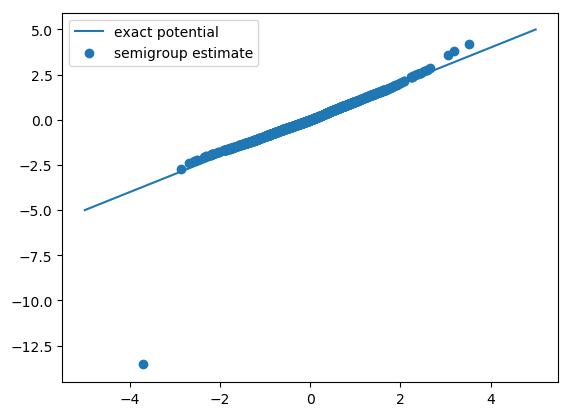

In [7]:
plot([x for x in -5:.1:5], [x for x in -5:.1:5])
scatter(eq.positions, eq.potential);
legend(("exact potential","semigroup estimate"));

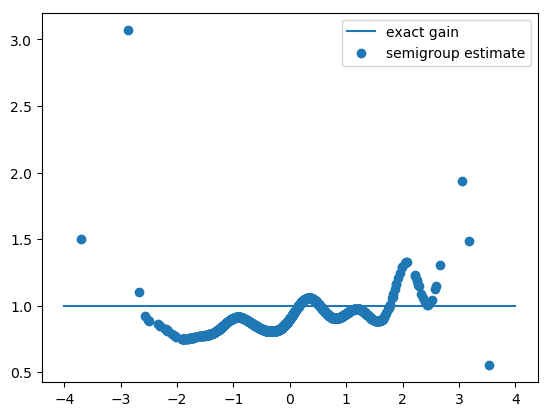

In [8]:
#ylim([0,2])
plot([x for x in -4:.1:4], [1 for x in -4:.1:4])
scatter(eq.positions, eq.gain);
legend(("exact gain","semigroup estimate"));

## Running simulations

Above, we looked at the gain estimation step, which is crucial for FPFs. 
But running a feedback particle filter simulation involves prediction as well as simulation of the hidden state and observation processes.
This is fully implemented in FeedbackParticleFilters.jl.

First, we define the filter to be run.
In this case, we use `N = 100` particles and we use the regularized semigroup method.

In [9]:
method = SemigroupMethod(1E-1, 1E-2, 1000, 1E-3)
filter = FPF(filt_prob, method, 100)

Feedback particle filter algorithm
    hidden state model:                     1-dimensional diffusion with 1-dimensional Brownian motion
    observation model:                      1-dimensional diffusion with 1-dimensional Brownian motion
    ensemble size:                          100
    gain estimation method:                 SemigroupMethod(0.1, 0.01, 1000, 0.001)

Then we set up a simulation for the filter for `n_time = 1000` time steps and a time discretization of `dt = 0.01`.

In [10]:
simulation = ContinuousTimeSimulation(filt_prob, filter, 1000, 0.01)

Continuous-time simulation
    filtering problem:                      ContinuousTime - ContinuousTime with DiffusionStateModel and DiffusionObservationModel{Float64,Float64,typeof(h)}
    filtering algorithm:                    FPF with 100 particles and SemigroupMethod(0.1, 0.01, 1000, 0.001)
    number of time steps:                   1000
    size of time step:                      0.01

Calling `run!` will perform the full simulation.
To monitor progress, a dot is shown every 100 time steps.

In [11]:
@time run!(simulation)

!!!!!!!!!!!!!!!!!!!!!!!!!!  2.936155 seconds (15.54 M allocations: 994.038 MiB, 8.53% gc time)


0×1000 Array{Any,2}

In addition to the ten dots, we also see some exclamation marks `!`.
An exclamation mark indicates that there was a time step in which the gain estimation did not converge within the `1000` iterations we provided.
This means that the gain that was used was suboptimal. 
If it happens only a handful of times during the course of `1000` time steps, this should not affect the filter performance too much.
In this case, increasing the number of iterations to `10000` solves the problem without significantly affecting simulation time.

In [12]:
method = SemigroupMethod(1E-1, 1E-2, 10000, 1E-3)
filter = FPF(filt_prob, method, 100);
simulation = ContinuousTimeSimulation(filt_prob, filter, 10000, 0.01)
@time run!(simulation);

  6.133988 seconds (27.81 M allocations: 3.000 GiB, 3.39% gc time)


### Recording simulation trajectories

Normally, the simulation is run without storing any intermediate values, such as the particle positions for intermediate time steps.
In order to record intermediate values, we can use the `SimulationState` which is propagated by the simulation.
The `SimulationState` contains the hidden state, observation, and the filter state at each time step:

In [13]:
fieldnames(SimulationState)

(:hidden_state, :obs, :filter_state)

These fields can be extracted using the functions `hidden_state`, `obs`, and `filter_state` that are provided.
For example, we want to extract the hidden state and the particle ensemble:

In [14]:
hs(x)  = hidden_state(x)
ens(x) = filter_state(x).ensemble;

In addition, one can define custom functions that perform some computations on the fly:
for example, this function computes the squared error:

In [15]:
se(x) = first(hs(x) - cond_mean(x))^2;

Calling `run!` with a keyword parameter that equals a tuple of functions will return an array with rows corresponding to the different functions, and columns corresponding to time steps:

In [32]:
simulation = ContinuousTimeSimulation(filt_prob, filter, 10000, 0.01)
@time output = run!(simulation, records = (hs, ens, se,));

  5.378219 seconds (27.15 M allocations: 2.835 GiB, 6.92% gc time)


In [17]:
output[1,1] # first hidden state

1-element Array{Float64,1}:
 1.3966301689383447

In [18]:
output[2,1] # first particle ensemble

Unweighted particle ensemble
    # of particles: 100
    particle type:  1-dimensional Array{Float64,1}

In [19]:
output[3,1] # first squared error

2.4394947301570404

We may now visualize the hidden state and filter trajectory:

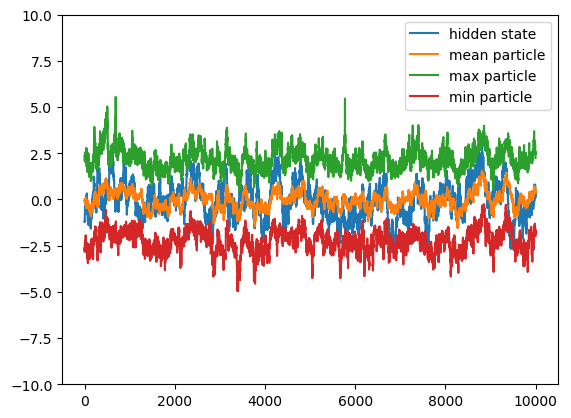

In [51]:
nn = 1:10000
ylim([-10,10])
plot(output[1,nn]);
plot(map(x->mean(x)[1], output[2,nn]));
plot(map(x->maximum(x.positions[1,:]), output[2,nn]));
plot(map(x->minimum(x.positions[1,:]), output[2,nn]));
#plot([minimum(rec.ensemble.positions) for rec in records[nn]]);
legend(("hidden state","mean particle","max particle","min particle"));

We can then evaluate the mean-squared error of the particle estimate...

In [22]:
mean(output[3,:])

0.732040457057439

...or the relative mean-squared error (i.e. MSE normalized by the prior variance):

In [35]:
mean(output[3,:]) / var(output[1,:])[1]

0.7883696454798562

### Recording further simulation details for troubleshooting

Sometimes it may be necessary to record further details about the simulation, for example the gain equation objects for gain estimation, in order to troubleshoot problems with the filtering algorithm.

Here, we define a function that extracts the gain equation:

In [38]:
eqn(x) = filter_state(x).eq

eqn (generic function with 1 method)

Let's run a slightly shorter simulation in order to see this in action:

In [40]:
simulation2 = ContinuousTimeSimulation(filt_prob, filter, 1000, 0.01);
@time output2 = run!(simulation2, records = (hs, ens, eqn,));

  0.661047 seconds (2.82 M allocations: 316.884 MiB, 5.04% gc time)


These are the simulated trajectories:

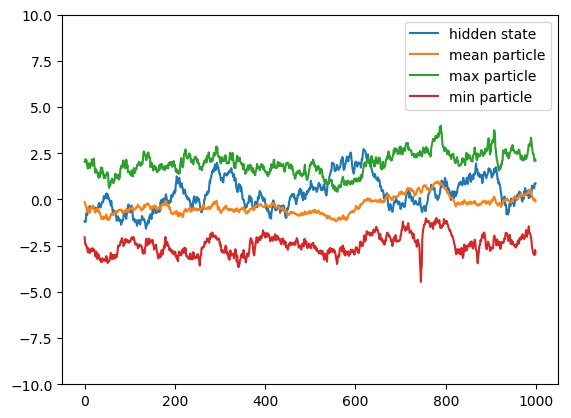

In [48]:
nn = 1:1000
ylim([-10,10])
plot(output[1,nn]);
plot(map(x->mean(x)[1], output2[2,nn]));
plot(map(x->maximum(x.positions[1,:]), output2[2,nn]));
plot(map(x->minimum(x.positions[1,:]), output2[2,nn]));
legend(("hidden state","mean particle","max particle","min particle"));

Since we included the `eq` field in the recording, we can now do things such as displaying all the gain estimates at once:

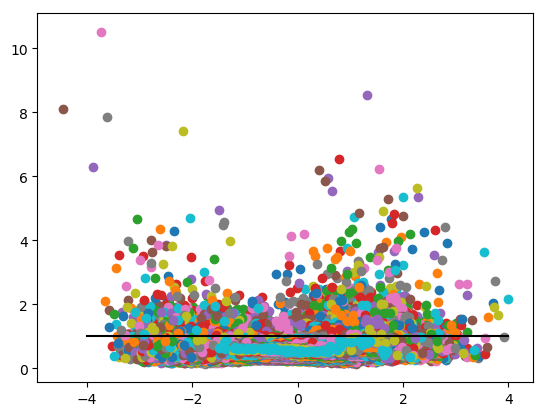

In [52]:
plot([x for x in -4:.1:4], [1 for x in -4:.1:4], color="black")
for i in 1:1000
    scatter(output2[3,i].positions[1,:], output2[3,i].gain);
end